# Random Forest Final Model

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [3]:
site = config.site
site_name = config.site_dict[site]
compound = config.compound

print(f"Exploring {compound} at {site_name}.")

Exploring ch2cl2 at Mace Head, Ireland.


### Loading & Initialising Data

In [4]:
data = pd.read_csv(data_path/'for_model_pca.csv', parse_dates=['time'])
data.sample(5)

,time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,flag
10296,2010-05-02 19:50:00,-13.503289,2.434403,2.257658,0.054526,1.419001,0.258298,1.381002,1.358031,1.146720,...,0.169676,0.130085,1.592792,0.577859,1.057431,0.276520,0.403748,1.135829,0.077331,1.0
10250,2010-04-04 14:21:00,-1.135578,0.396661,1.063558,4.075485,5.977330,2.461019,-3.326527,-1.797675,0.282842,...,-1.777167,-0.242580,-0.721334,0.234011,-0.612741,0.375524,0.666086,0.533747,0.784977,1.0
9524,2009-07-02 22:41:00,0.936018,11.653263,2.998928,0.077999,0.473669,0.459048,-0.504847,-0.119139,1.009601,...,-0.583314,-0.627178,-0.427016,-0.577548,-1.920058,-0.492567,-0.253626,1.790473,0.219491,0.0
12109,2011-12-24 16:19:00,5.070052,-7.149243,-7.390926,-0.871966,1.242856,-0.397560,1.875728,0.313298,0.052109,...,1.311766,-0.524631,1.054252,-1.097402,-1.013153,-1.932349,0.088072,0.614058,-0.849371,1.0
6843,2007-01-24 12:27:00,-17.077004,3.202798,1.937862,-0.473748,-0.976504,-2.881753,0.000075,1.236787,-1.290514,...,-0.637460,-0.916590,2.811722,2.443556,-0.312029,0.799701,-1.215974,0.401403,0.922003,0.0


In [5]:
if compound == 'ch2cl2':
    train_data = data[(data['time'].dt.year >= 2010) & (data['time'].dt.year <= 2012)]
    val_data = data[(data['time'].dt.year >= 2013) & (data['time'].dt.year <= 2013)]
    test_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2016)]

else:
    train_data = data[(data['time'].dt.year >= 2016) & (data['time'].dt.year <= 2018)]
    val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
    test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")

# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])


# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']


# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2010-01-02 04:02:00 -> 2012-12-31 22:29:00. Length: 3295
Val range: 2013-01-01 00:29:00 -> 2013-12-30 09:25:00. Length: 847
Test range: 2014-01-02 20:09:00 -> 2016-12-31 21:51:00. Length: 3285


### Model

In [6]:
# fitting models based on optimal hyperparameters

rf_model = RandomForestClassifier(random_state=42,
                                  n_estimators=100,
                                  max_depth=5,
                                  criterion='entropy',
                                  bootstrap=False,)

rf_model.fit(X_train, y_train)

class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = config.confidence_threshold

y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.953
Precision on Validation Set = 0.948
Recall on Training Set = 0.818
Recall on Validation Set = 0.773
F1 Score on Training Set = 0.881
F1 Score on Validation Set = 0.851


C:\Users\kirst\AppData\Local\Temp\ipykernel_4784\3156113180.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_importances.index)


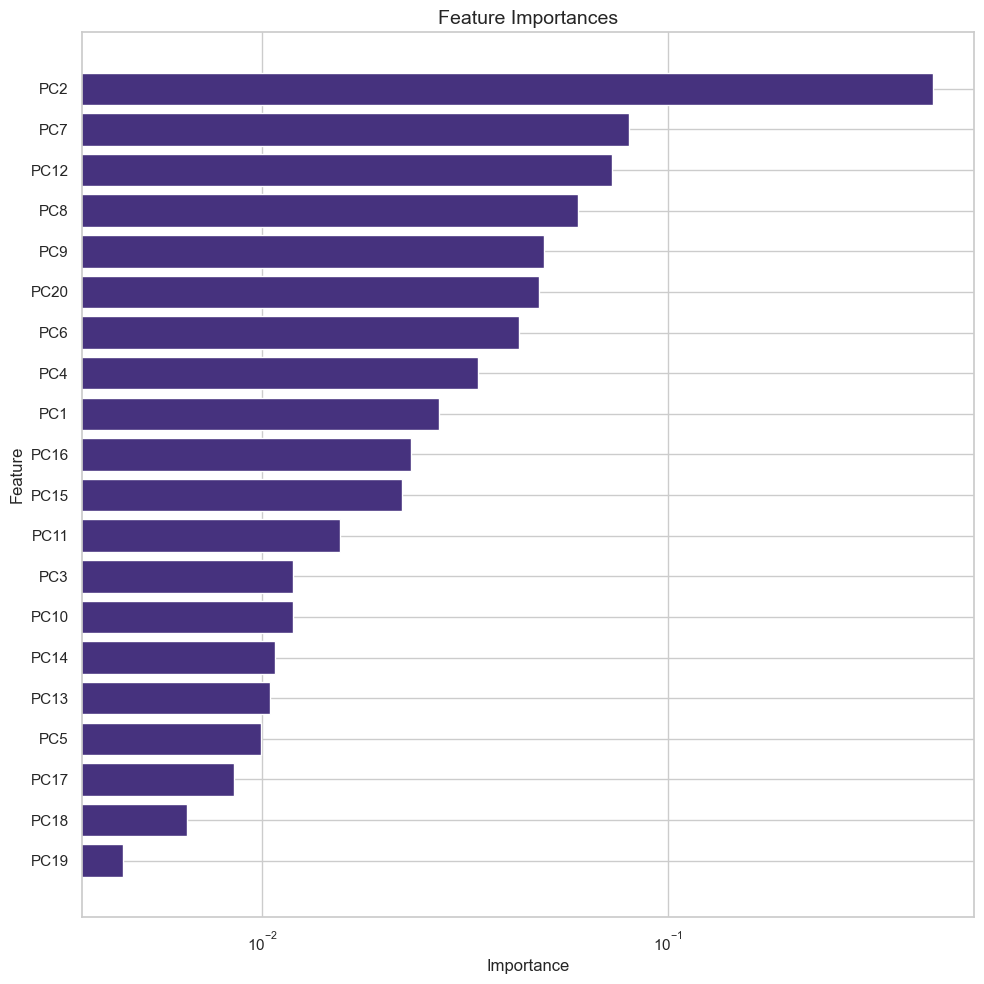

In [18]:
# finding most important features in the model

feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style='whitegrid')
sns.set_palette("viridis")

# sorting feature importances
feature_importances = feature_importances.sort_values('importance', ascending=True)

# bar chart of feature importances
ax.barh(feature_importances.index, feature_importances['importance'])

# making y axis logaritmic
ax.set_xscale('log')

ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances', fontsize=14)
ax.set_yticklabels(feature_importances.index)

fig.tight_layout()

In [8]:
# evaluating the model on the test set

class_probabilities_test = rf_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_test:.3f}")

Precision on Test Set = 0.929
Recall on Test Set = 0.742
F1 Score on Test Set = 0.825


In [9]:
# saving model

dump(rf_model, data_path/'rf_model.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\rf_model.joblib']